# Data Generation for Physics-informed DeepONets for quantum graphs

## Import necessary packages

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.70'

import matplotlib.pyplot as plt
%matplotlib widget

import numpy as np


import jax.numpy as jnp
from jax import random, grad, vmap, jit, config
import jax


from tqdm import tqdm

from functools import partial
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
import itertools
from jax import device_put
from jax.example_libraries import optimizers
import pickle

import sys

from src.quantumGraphSolverFVM import QuantumGraphSolverFVM
from src.graph import Example0, Example1, Example2, Example3, Example4, Example5, Example6

# Use Gaussian processes to generate inflow, outflow and initial conditions randomly
from src.GPs import get_sample_fns


## Plot training graphs

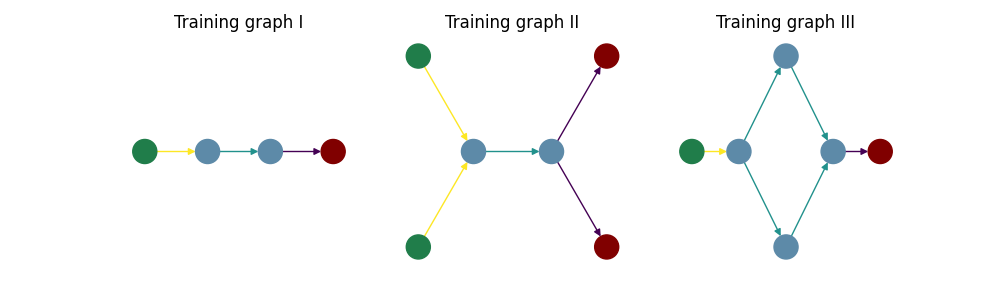

In [2]:
e2 = Example2()
e4 = Example4()
e6 = Example6()

# Plot example graphs
[fig, axs] = plt.subplots(1, 3, figsize=(10,3))

e2.plotGraph(ax=axs[1])
e4.plotGraph(ax=axs[0])
e6.plotGraph(ax=axs[2])

plt.show()

The various training graph give the following number of edges:
- Training graph I: one inflow, one inner, one outflow
- Training graph II: two inflow, one inner, two outflow
- Training graph III: one inflow, four inner, one outflow

## Set up function to solve problem using the FV solver for simulated input to generate training data

In [20]:
SEED = 1

# Set path were data gets stored
DATA_PATH = './PI_DeepONet_Data'

# Data quality middle
FVM_NX = 200
FVM_NT = 1000
N_DATA_BC = 100
N_DATA_INIT = 100
N_DATA_RES = 2500

# N_DATA_SAMPLES = 100
# N_DATA_BATCHES = 20

# Only for testing
N_DATA_SAMPLES = 10
N_DATA_BATCHES = 2

# Data quality high
if False:
    FVM_NX = 1000
    FVM_NT = 2000
    N_DATA_BC = 100
    N_DATA_INIT = 100
    N_DATA_RES = 2500

    N_DATA_SAMPLES = 100
    N_DATA_BATCHES = 100
    
EPS = 0.1

FN_NAME = f'{DATA_PATH}/variable_velocity_eps{EPS}_n{N_DATA_SAMPLES}_nx{FVM_NX}_nt{FVM_NT}'

BND_STEPS = int(FVM_NT / N_DATA_BC)

N_SPLIT = 50
USE32BIT = True

N = 512
LENGTH_SCALE = 0.5

key = random.PRNGKey(0) # use different key for generating test data 

# Set up Gaussian Process matrix
sample_u_in_fn, sample_u_out_fn, sample_u_init_fn = get_sample_fns(N=N, length_scale=LENGTH_SCALE)
#X = jnp.linspace(0, 1, N)

# Sensor locations of initial and boundary measurements
x_sensor_bc = jnp.linspace(0, 1, N_DATA_BC+1)
x_sensor_init = jnp.linspace(0, 1, N_DATA_INIT+1)

# Locations of residual values inside domain
T_RES, X_RES = jnp.meshgrid(jnp.linspace(0, 1, FVM_NT + 1),
                            jnp.linspace(0, 1, FVM_NX + 1))

In [21]:
def fvm_solve(graph, nx=200, nt = 1000):
    fvm_solver = QuantumGraphSolverFVM(graph)
    v = fvm_solver.solve(nx=nx + 1, nt=nt + 1)
    v0 = jnp.array([fvm_solver.get_u_edge(v.T, i).T for i in range(graph.ne)])[None,:,:]
    return v0

In [22]:
def draw_random_velocity(graph, key, vmin=0.4, vmax=2.1):
    v_current = graph.v
    return random.uniform(key, v_current.shape, minval=vmin, maxval=vmax)

## Generate function which stores data efficiently

In [23]:
def gen_data(n_samples, key, graph_class, TimeOffset=0.1):

    # Prepare lists to store data temporarily
    u_base_inflow = []
    y_res_inflow = []
    s_res_inflow = []
    s_bc_inflow = []
    
    u_base_inner = []
    y_res_inner = []
    s_res_inner = []
    s_bc_inner = []
    
    u_base_outflow = []
    y_res_outflow = []
    s_res_outflow = []
    s_bc_outflow = []

    g = graph_class()
    
    n_edges = g.ne
    n_vertices = g.n_v
    n_DirichletNodes = len(g.dirichletNodes)
    DX = (g.ub[1] - g.lb[1]) / FVM_NX
    
    for i in tqdm(range(n_samples)):
        #print(f'Compute data set {i+1} / {n_samples}')

        # Generate keys for random inflow, outflow, initial conditions
        keys = random.split(key, n_edges + n_DirichletNodes + 2)
        key = keys[0]
        edge_keys = keys[1:n_edges + 1]
        inflow_keys = keys[n_edges + 1:n_edges + 1 + len(g.inflowNodes)]
        outflow_keys = keys[-len(g.outflowNodes)-1:-1]
        res_key = keys[-1]



        # Set up boundary and initial conditions as functions using numpy arrays
        def dirichletAlpha(t):
            z = np.zeros(n_vertices)
            z[g.inflowNodes] = np.array([sample_u_in_fn(k)(t) for k in inflow_keys])
            return z
        
        def dirichletBeta(t):
            z = np.zeros(n_vertices)
            z[g.outflowNodes] = np.array([sample_u_out_fn(k)(t) for k in outflow_keys])
            return z

        def initial_cond(x):
            return np.array([sample_u_init_fn(k)(x) for k in edge_keys])
            
        def initial_cond_jnp(x):
            return jnp.array([sample_u_init_fn(k)(x) for k in edge_keys])
        
        graph = graph_class(eps=EPS,
                        dirichletAlpha=dirichletAlpha,
                        dirichletBeta=dirichletBeta,
                        initial_cond=initial_cond,
                        initial_cond_jnp=initial_cond_jnp)

        # Draw and set random velocity
        key, vel_key = random.split(key, 2)
        vel = draw_random_velocity(graph, vel_key)
        graph.v = np.array(vel)
       
        graph.lb[0] -= TimeOffset

        # Solve PDE on graph using the FVM solver on fine grid using extended time grid
        v = fvm_solve(graph, nx=FVM_NX, nt=int(FVM_NT * (1 + TimeOffset)))[0]
        
        # Restrict solution to original domain
        v = v[:, :, int(TimeOffset*FVM_NT):]
        
        # Retrieve updated initial conditions
        v_init = v[:, :, 0]

        # Split res key
        res_keys = random.split(res_key, n_edges)
        
        # Loop over edges
        for i, e in enumerate(graph.E):

            u_init = jnp.interp(x_sensor_init, jnp.linspace(0, 1, FVM_NX + 1), v_init[i])
            
            # Randomly select N_DATA_RES many of those values to store
            idx_res = random.choice(res_keys[i], (FVM_NT - 1) * (FVM_NX - 1), (N_DATA_RES,), replace=False)
            
            # Append data to lists
            # NOTE: We exclude points at the boundaries 
            y_res = jnp.hstack([T_RES[1:-1, 1:].reshape((-1,1))[idx_res],
                                X_RES[1:-1, 1:].reshape((-1,1))[idx_res]])
            s_res = v[i, 1:-1, 1:].reshape((-1,1))[idx_res]

            s_bc = jnp.hstack([v[i][[0],::BND_STEPS].T,
                               v[i][[-1], ::BND_STEPS].T])
            if e[0] in graph.inflowNodes:
                
                # Inflow edge
                idx_0 = np.where(e[0] == graph.inflowNodes)[0]
                # Inflow
                u_inflow = sample_u_in_fn(inflow_keys[idx_0].squeeze())(x_sensor_bc)

                # Right flow
                v_edge =  v[i, -1, ::BND_STEPS]
                vx_edge = (v[i,-1, ::BND_STEPS] - v[i, -2, :: BND_STEPS]) / (DX)
                u_right_flow = graph.flux(v_edge, vx_edge, i)

                # Store inflow edge
                u_base_inflow.append(jnp.hstack([u_inflow, u_right_flow, u_init, vel[i]]))
                y_res_inflow.append(y_res)
                s_res_inflow.append(s_res)
                s_bc_inflow.append(s_bc)

            elif e[1] in graph.outflowNodes:
                
                # Outflow edge
                idx_1 = np.where(e[1] == graph.outflowNodes)[0]

                # Outflow
                u_outflow = sample_u_out_fn(outflow_keys[idx_1].squeeze())(x_sensor_bc)

                # Left flow
                v_edge =  v[i, 0, ::BND_STEPS]
                vx_edge = (v[i, 1, ::BND_STEPS] - v[i, 0, :: BND_STEPS]) / (DX)
                u_left_flow = graph.flux(v_edge, vx_edge, i)

                # Store outflow edge
                u_base_outflow.append(jnp.hstack([u_left_flow, u_outflow, u_init, vel[i]]))
                y_res_outflow.append(y_res)
                s_res_outflow.append(s_res)
                s_bc_outflow.append(s_bc)

            else:
                # Inner edge            
                # Left flow
                v_edge =  v[i, 0, ::BND_STEPS]
                vx_edge = (v[i, 1, ::BND_STEPS] - v[i, 0, :: BND_STEPS]) / (DX)
                u_left_flow = graph.flux(v_edge, vx_edge, i)

                # Right flow
                v_edge =  v[i, -1, ::BND_STEPS]
                vx_edge = (v[i,-1, ::BND_STEPS] - v[i, -2, :: BND_STEPS]) / (DX)
                u_right_flow = graph.flux(v_edge, vx_edge, i)
            
                # Store inner edge
                u_base_inner.append(jnp.hstack([u_left_flow, u_right_flow, u_init, vel[i]]))
                y_res_inner.append(y_res)
                s_res_inner.append(s_res)
                s_bc_inner.append(s_bc)
        
    if USE32BIT:
        prep = lambda x: jnp.float32(jnp.array(x))
    else:
        prep = lambda x: jnp.array(x)

    u_base_inflow = prep(u_base_inflow)
    y_res_inflow = prep(y_res_inflow)
    s_res_inflow = prep(s_res_inflow)
    s_bc_inflow = prep(s_bc_inflow)
    
    u_base_inner = prep(u_base_inner)
    y_res_inner = prep(y_res_inner)
    s_res_inner = prep(s_res_inner)
    s_bc_inner = prep(s_bc_inner)
    
    u_base_outflow = prep(u_base_outflow)
    y_res_outflow = prep(y_res_outflow)
    s_res_outflow = prep(s_res_outflow)
    s_bc_outflow = prep(s_bc_outflow)

    RES_DATA_INFLOW = (u_base_inflow, y_res_inflow, s_res_inflow)
    INIT_DATA_INFLOW = (u_base_inflow, x_sensor_init)
    BC_DATA_INFLOW = (u_base_inflow, x_sensor_bc, s_bc_inflow)

    RES_DATA_INNER = (u_base_inner, y_res_inner, s_res_inner)
    INIT_DATA_INNER = (u_base_inner, x_sensor_init)
    BC_DATA_INNER = (u_base_inner, x_sensor_bc, s_bc_inner)
    
    RES_DATA_OUTFLOW = (u_base_outflow, y_res_outflow, s_res_outflow)
    INIT_DATA_OUTFLOW = (u_base_outflow, x_sensor_init)
    BC_DATA_OUTFLOW = (u_base_outflow, x_sensor_bc, s_bc_outflow)
    
    return RES_DATA_INFLOW, INIT_DATA_INFLOW, BC_DATA_INFLOW, \
        RES_DATA_INNER, INIT_DATA_INNER, BC_DATA_INNER, \
        RES_DATA_OUTFLOW, INIT_DATA_OUTFLOW, BC_DATA_OUTFLOW, \
        key

## Select training graph and generate data

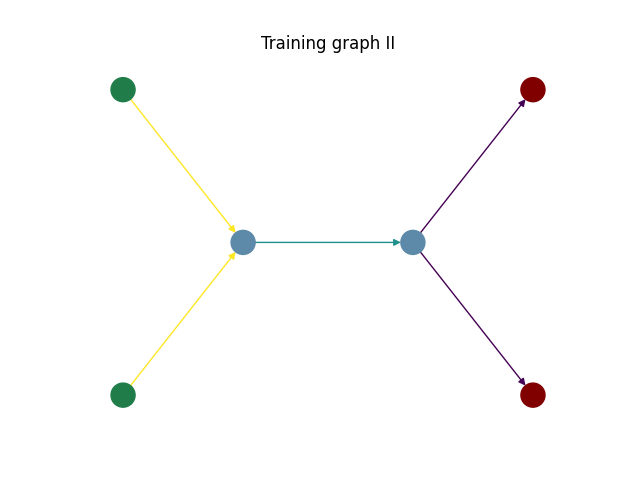

In [28]:
# In order to train the model you have to generate data for all example graphs
graph_class = Example2
#graph_class = Example4
#graph_class = Example6

g = graph_class()
fig, ax = plt.subplots(1,1)
g.plotGraph(ax=ax)

gen_key = random.PRNGKey(0)

In [29]:
GEN_DATA = True
if GEN_DATA:
    for i in range(N_DATA_BATCHES):
        print(f'Batch {i+1} / {N_DATA_BATCHES}')
        config.update("jax_enable_x64", True)
        ret = gen_data(n_samples=N_DATA_SAMPLES, key=gen_key, graph_class=graph_class)
        config.update("jax_enable_x64", False)

        os.makedirs(os.path.join(FN_NAME, f'example_{g.id}'), exist_ok=True)
        FN_NAME_RUN = os.path.join(FN_NAME, f'example_{g.id}', f'run_{i:05}')
        
        # Save data
        jnp.savez(FN_NAME_RUN,
                  RES_INFLOW0 = ret[0][0],
                  RES_INFLOW1 = ret[0][1],
                  RES_INFLOW2 = ret[0][2],
                  INIT_INFLOW0 = ret[1][0],
                  INIT_INFLOW1 = ret[1][1],
                  BC_INFLOW0 = ret[2][0],
                  BC_INFLOW1 = ret[2][1],
                  BC_INFLOW2 = ret[2][2],
                  RES_INNER0 = ret[3][0],
                  RES_INNER1 = ret[3][1],
                  RES_INNER2 = ret[3][2],
                  INIT_INNER0 = ret[4][0],
                  INIT_INNER1 = ret[4][1],
                  BC_INNER0 = ret[5][0],
                  BC_INNER1 = ret[5][1],
                  BC_INNER2 = ret[5][2],
                  RES_OUTFLOW0 = ret[6][0],
                  RES_OUTFLOW1 = ret[6][1],
                  RES_OUTFLOW2 = ret[6][2],
                  INIT_OUTFLOW0 = ret[7][0],
                  INIT_OUTFLOW1 = ret[7][1],
                  BC_OUTFLOW0 = ret[8][0],
                  BC_OUTFLOW1 = ret[8][1],
                  BC_OUTFLOW2 = ret[8][2],
                 )

        gen_key = ret[9]

Batch 1 / 2


100%|█████████| 10/10 [00:30<00:00,  3.09s/it]


Batch 2 / 2


100%|█████████| 10/10 [00:30<00:00,  3.06s/it]
